# Clean up the full train and test datasets

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
from IPython.display import display, HTML
from sklearn.preprocessing import Imputer
from sklearn.base import TransformerMixin
from sklearn import linear_model

## Load Data

In [3]:
train_file = "../data/train.csv"
train = pd.read_csv(train_file, index_col=0)

test_file = "../data/test.csv"
test = pd.read_csv(test_file, index_col=0)

## Clean the data

### Impute the numeric data

In [5]:
cols_numeric = train.select_dtypes(include=[np.number]).columns.tolist()

# Don't want to impute on sale price...
cols_numeric.remove('SalePrice')

# Look down each column and replace missing values with the median of that column 
# (since we're using integers, median seemed to make more sense)
# Imputer is trained on the training data, NOT the test data!
imp_numeric = Imputer(missing_values='NaN', strategy='median', axis=0)
imp_numeric.fit(train[cols_numeric])

# train_imputed = train.copy()
train[cols_numeric] = imp_numeric.transform(train[cols_numeric])
# test_imputed  = test.copy()
test[cols_numeric]  = imp_numeric.transform(test[cols_numeric])

### Handle the non-numeric columns

### sklearn has OneHotEncoder, but pandas now has a built in get_dummies()
see:
* http://fastml.com/converting-categorical-data-into-numbers-with-pandas-and-scikit-learn/
* http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html

Make an imputer for categoricals.  Inherrit the TransformerMixin for .fit and .transform

In [11]:
class CategoricalImputer(TransformerMixin):
    
    def __init__(self):
        """Impute missing categorical values by replacing them with the most common value.
        
        Adapted from http://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn
        """
        
    def fit(self, X, y=None):
        # Make a pd.Series that has a fill value for each column (use np.nan for anything non-categorical)
        self.fill = pd.Series([X[c].value_counts().index[0] if X[c].dtype == np.dtype('O') else np.nan for c in X ], index=X.columns)
        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.fill)
    
# Example:

# data = [
#     ['a', 1, 2],
#     ['b', 1, 1],
#     ['b', 2, 2],
#     [np.nan, np.nan, np.nan]
# ]

# X = pd.DataFrame(data)
# xt = CategoricalImputer().fit_transform(X)

# print('before...')
# print(X)
# print('after...')
# print(xt)

Get the non-numeric columns


In [8]:
cols_non_numeric = train.select_dtypes(exclude=[np.number]).columns.tolist()


Many columns have nan, but from the description several use nan as a value.  Only fix the ones that shouldn't have nan

In [14]:
# Make lists for datasets that could intentionally have nan (typically they mean "I don't have this feature")
# Any record with a nan in a basement category should have a nan in all basement categories.  Same with garage.  
# Groupd those to check
nan_bsmt = ['BsmtQual', 'BsmtCond', 'BsmtExposure']
nan_garage = ['GarageType', 'GarageQual', 'GarageFinish', 'GarageCond']
nan_intentional = ['Alley', 
                   'FireplaceQu', 
                   'PoolQC', 'Fence', 'MiscFeature',] + nan_bsmt + nan_garage

# Get the other nan's (this would have been easier to just type the unintentional ones, but I was already done listing the intentionals..)
# Need to get nan from both train and test.  Get them separately then combine by using sets
nan_unintentional_train = set([train[cols_non_numeric].iloc[:,x].name for x in pd.isnull(train[cols_non_numeric]).any().nonzero()[0] if train[cols_non_numeric].iloc[:,x].name not in nan_intentional ])
nan_unintentional_test = set([test[cols_non_numeric].iloc[:,x].name for x in pd.isnull(test[cols_non_numeric]).any().nonzero()[0] if test[cols_non_numeric].iloc[:,x].name not in nan_intentional ])
nan_unintentional = list(nan_unintentional_train) + list(nan_unintentional_test-nan_unintentional_train)

nan_rows_train = pd.isnull(train[nan_unintentional]).any(1).nonzero()[0]
nan_rows_train_byId = train.index[nan_rows_train]
nan_rows_test = pd.isnull(test[nan_unintentional]).any(1).nonzero()[0]
nan_rows_test_byId = test.index[nan_rows_test]

imp_categorical = CategoricalImputer()
imp_categorical.fit(train[nan_unintentional])
# train_imputed_categorical = train.copy()
train[nan_unintentional] = imp_categorical.transform(train[nan_unintentional])

# And same for test
test[nan_unintentional] = imp_categorical.transform(test[nan_unintentional])

# Predict using Categoricals

## Simple prediction to see if it is working...

First fit a simple linear regression model relating OverallQual (which is a 1-10 numeric feature) to SalePrice

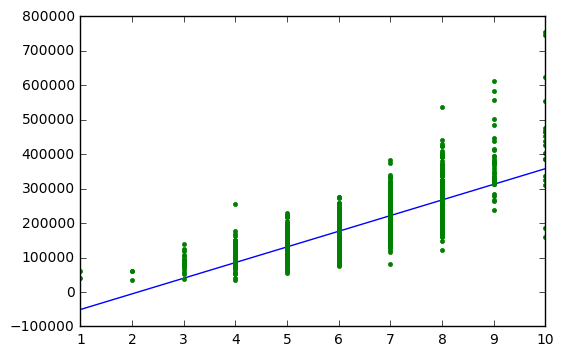

In [16]:
estimator = linear_model.LinearRegression(normalize=True)
estimator.fit(train[['OverallQual']], train['SalePrice'])

x = np.linspace(1,10,10)
dfx = pd.DataFrame(data=x, columns=['OverallQual'])
plt.plot(x, estimator.predict(dfx), '-')
plt.plot(train['OverallQual'], train['SalePrice'], '.')

Now regress by pretending OverallQual is categorical (which it sort of is, it was just represented using numbers).  Use one-hot method to translate "categorical" to boolean features

Index(['OverallQual_2.0', 'OverallQual_3.0', 'OverallQual_4.0',
       'OverallQual_5.0', 'OverallQual_6.0', 'OverallQual_7.0',
       'OverallQual_8.0', 'OverallQual_9.0', 'OverallQual_10.0'],
      dtype='object')


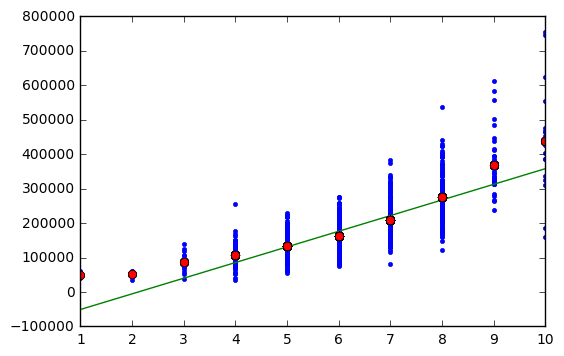

In [22]:
train_simple_OQ = pd.get_dummies(train[['OverallQual']], columns=['OverallQual'])

# Leave one out as you need k-1 indicators for k total results (think of how you need one boolean indicator to represent two results)
features = train_simple_OQ.columns[1::]
print(features)
m = linear_model.LinearRegression(normalize=True) # Does normalize do anything here?
m.fit(train_simple_OQ[features], train['SalePrice'])

# This is overkill on the plotting.  I could just make a very simple identity matrix to plot all these predictions.
# ...but I'm lazy..
plt.plot(train['OverallQual'], train['SalePrice'], '.')
plt.plot(x, estimator.predict(dfx), '-')
plt.plot(train['OverallQual'], m.predict(train_simple_OQ[features]), 'o')

Looks even better than the linear regression on the numerics!  ...Although it has more features...

Investigating the model we get

In [23]:
print(m.intercept_)
list(zip(features, m.coef_))

50150.0


[('OverallQual_2.0', 1620.3333333350231),
 ('OverallQual_3.0', 37323.750000001535),
 ('OverallQual_4.0', 58270.655172415318),
 ('OverallQual_5.0', 83373.347607054005),
 ('OverallQual_6.0', 111453.03475935977),
 ('OverallQual_7.0', 157566.42319749325),
 ('OverallQual_8.0', 224585.53571428699),
 ('OverallQual_9.0', 317363.02325581585),
 ('OverallQual_10.0', 388438.38888889045)]

Ok this makes sense.  So having a quality of say 8 adds $225000 to your house

Note: If we had left OverallQual_10 out, we'd instead have a very high intercept and lots of negative values

## Next Steps
* Make a simple model with sqft + sale quality.  Submit to Kaggle.  Did it get better score than the old one?  Maybe use a few polynomials on sqft but dont go overboard?  Could always do linear+quality, then a few polys+qual, etc.
* Add a few extra categoricals to that same model.
* Expand to the entire set of categoricals and apply with RidgeCV.  How crazy does that get?  Does it give a better fit?
* Use the entire set of categoricals with LassoCV.  How good is that fit?
* Use LassoCV's selected features and then refit with RidgeCV.  Improvement on Lasso?
* Use the feature selection from scipy, does the feature set seem similar to Lasso?  Try Ridge with those features...  
* Were there other things I used in the sqft/simple model?

## Train sqft + OverallQual

### Make DataFrame and New Features

In [28]:
def feat_eng_polys(df, feat, pwrs, inplace=True):
    """
    Given a dataframe and a feature, return a new (add to existing?) dataframe new features that are the pwrs'th power of the feature.
    
    :param pwrs:
        NOT IMPLEMENTED If pwrs=int, return all powers from 1 to that number.
        NOT IMPLEMENTED If pwrs=float, return that power.
        If pwrs=iterable, return the powers included in pwrs
    """
    f_new = []
    if inplace is not True:
        df_new = pd.DataFrame(index=df.index)
    else:
        df_new = df
    for p in pwrs:
        f_new.append('{:s}_{:s}'.format(feat, str(p)))
        df_new[f_new[-1]] = df[feat] ** p

    # Does it matter if this gets returned when doing inplace=True?
    return df_new, f_new

In [58]:
def get_RSS(d1, d2):
    return ((np.asarray(d1) - np.asarray(d2)) ** 2).sum()
def get_RMS(d1, d2):
    return np.sqrt(get_RSS(d1, d2)) / len(d1)

Add new features
* TotLivSF
* TotLivSF^N
* One-hot of OverallQual

In [73]:
data = {'train': train.copy(),
        'test': test.copy()}

cat_features = ['OverallQual']

for k in data.keys():
    # Make Total Living Square Footage
    data[k].loc[:, 'TotLivSF'] = data[k]['GrLivArea'] + data[k]['BsmtFinSF1'] + data[k]['BsmtFinSF2']
    # And sqrt of that
#     data[k][:, 'TotLivSF_sqrt'] = np.sqrt(data[k]['TotLivSF'])
    # And 2nd to 5th power
    data[k], f_new_poly  = feat_eng_polys(data[k], 'TotLivSF', range(2,6), inplace=True)
    
    # Add one-hot categoricals
    # Not sure if this is the best way to get the features, but using a temp variable to store the new features.
    # Could also get a set of data[k].columns before and after and take the difference
    temp =  pd.get_dummies(data[k][cat_features], columns=cat_features)
    f_new_cat = list(temp.columns)
    data[k] = pd.concat([data[k], temp], axis=1)
    
# Make a features list including the new polys and all the categoricals but one
features = ['TotLivSF'] + f_new_poly + f_new_cat[1:]
print("Features for fitting: {0}".format(features))


Features for fitting: ['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4', 'TotLivSF_5', 'OverallQual_2.0', 'OverallQual_3.0', 'OverallQual_4.0', 'OverallQual_5.0', 'OverallQual_6.0', 'OverallQual_7.0', 'OverallQual_8.0', 'OverallQual_9.0', 'OverallQual_10.0']


Train a RidgeCV model using these features

In [74]:
alphas = np.logspace(-6,5,12)
m = linear_model.RidgeCV(normalize=True, alphas=alphas)
m.fit(data['train'][features], train[['SalePrice']])

RidgeCV(alphas=array([  1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=True,
    scoring=None, store_cv_values=False)

In [75]:
print(m.coef_)

[[  2.80750425e+01   4.31453867e-03   2.40963901e-08  -2.94715659e-11
   -3.00556564e-15  -6.53717236e+04  -4.92404343e+04  -3.73898384e+04
   -2.58492154e+04  -6.32140658e+03   3.11486076e+04   7.68739167e+04
    1.51254519e+05   1.87001735e+05]]


In [77]:
predictions = m.predict(data['train'][features])
RMS = get_RMS(data['train']['SalePrice'], predictions)
RSS = get_RSS(data['train']['SalePrice'], predictions)
print("RSS={:8e}, RMS={:8.2f}".format(RSS, RMS))

RSS=2.425835e+16, RMS=106678.72


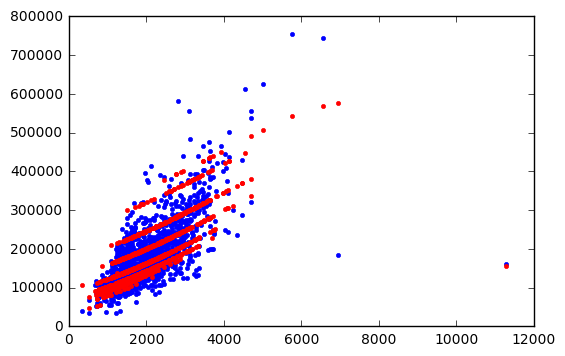

In [78]:
plt.plot(data['train']['TotLivSF'], data['train']['SalePrice'], 'b.')
plt.plot(data['train']['TotLivSF'], m.predict(data['train'][features]), 'r.')

**Something seems too high about a 100k RMS.  Is this right?  Or does quality really ruin the prediction?
WAIT, I didn't remove the outliers.  Is that it???
**